# XCOBRAS - Test 01
#### eXplainable COnstraint-Based Repeated Aggregation and Splitting
###### Yacine MOKHTARI - M2 Data Science


## I. Import + Load Data

In [4]:
# ------- IMPORTS
# -- model(s)
from cobras_ts.querier.labelquerier import LabelQuerier
from xcobras_kmeans import XCOBRAS_kmeans

# -- plot(s)
from utils.plots import plot_2D, plot_boundary
import matplotlib.pyplot as plt

# -- dataset(s) 
from sklearn import datasets
from scipy.io import arff
import pandas as pd
import numpy as np

# -- others
import warnings
warnings.filterwarnings("ignore")


# ------- CREATE TOY DATASET
n_samples = 500
X_blob0, y_blob0 = datasets.make_blobs(n_samples=n_samples, centers=3, n_features=2, random_state=0)
X_blob1, y_blob1 = datasets.make_blobs(n_samples=n_samples, centers=3, n_features=2, random_state=1)
X_moons1, y_moons1 = datasets.make_moons(n_samples=n_samples, noise=0.1, random_state=1)
# on verra comment les print

# ------- READ REAL DATASET
PATH = "../../datasets/deric benchmark/"
ARTIFICIAL = PATH+"artificial/"
REALWORLD = PATH+"real-world/"

datasets_path = [
    ARTIFICIAL+"target",
    REALWORLD+"wine",
    REALWORLD+"iris"
]

data = {}
for dataset_path in datasets_path:
    temp_data = arff.loadarff(open(dataset_path+".arff", 'r'))
    dataset_name = dataset_path.split("/")[-1]
    data[dataset_name] = pd.DataFrame(temp_data[0])
    data[dataset_name]["class"] = data[dataset_name]["class"].str.decode('utf-8') 

In [5]:
# ------- TRAIN MODEL
# clf = XCOBRAS_kmeans()
# _ = clf.fit(X, LabelQuerier(y))
# clf.predict(np.array([X[0]]))

## II. Models Training + Data Visualization

### i. First two features

XCOBRAS on the dataset: target


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------
XCOBRAS on the dataset: wine


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------
XCOBRAS on the dataset: iris


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------


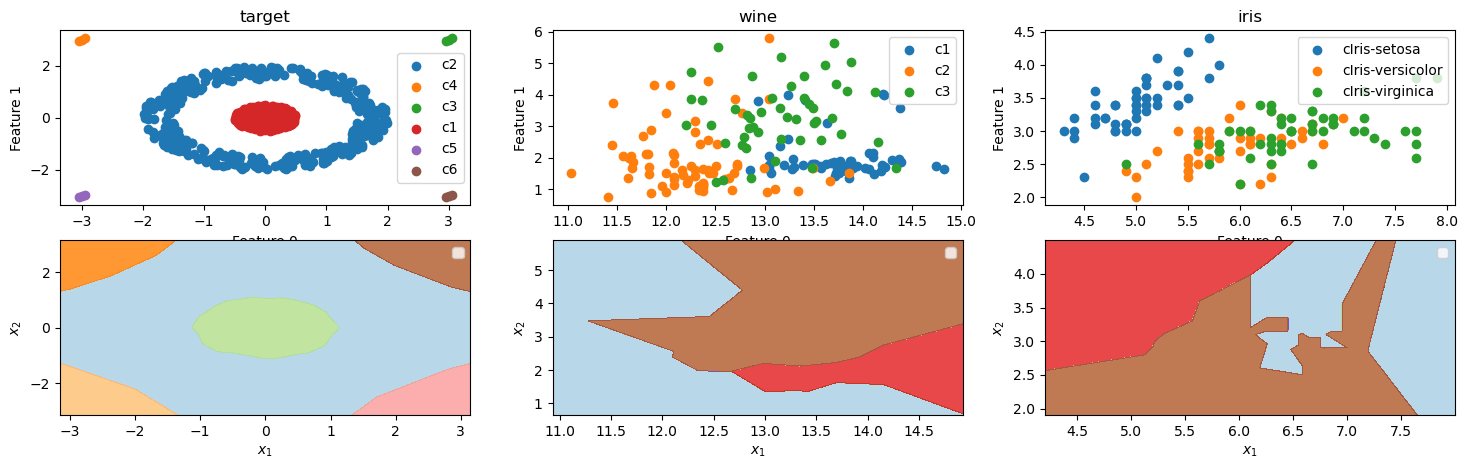

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(18,5))

for i, name in enumerate(data.keys()):
    print(f"XCOBRAS on the dataset: {name}")
    X = data[name].drop(["class"], axis=1).values
    y = data[name]["class"].values

    budget = np.max([60, X.shape[0]//5]
                    )
    xcobras_kmeans = XCOBRAS_kmeans(budget)
    _ = xcobras_kmeans.fit(X[:, :2], LabelQuerier(y))
    # axs[0]: ground truth clustering
    plot_2D(X[:, :2], y, axs[0][i], pca_t = False, title=name)

    # axs[1]: XCOBRAS_kmeans clustering
    plot_boundary(xcobras_kmeans, X[:, :2], axs[1][i])

    print(f"------")

### ii. First two PC (using PCA)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18,5))

for i, name in enumerate(data.keys()):
    print(f"XCOBRAS on the dataset: {name}")
    X = data[name].drop(["class"], axis=1).values
    y = data[name]["class"].values

    budget = np.max([60, X.shape[0]//5])
    
    xcobras_kmeans = XCOBRAS_kmeans(budget)
    _ = xcobras_kmeans.fit(X[:, :2], LabelQuerier(y))
    # axs[0]: ground truth clustering
    plot_2D(X[:, :2], y, axs[0][i], title=name)

    # axs[1]: XCOBRAS_kmeans clustering
    plot_boundary(xcobras_kmeans, X[:, :2], axs[1][i])

    print(f"------")

## III. Feature Impotance - (inspired from the EXPLAIN-IT framework)

### 0. COBRAS - Example on the "wine" dataset

In [10]:
X = data["wine"].drop(["class"], axis=1).values
y = data["wine"]["class"].values

budget = 35

xcobras_kmeans = XCOBRAS_kmeans(budget)
xcobras_kmeans.fit(X, LabelQuerier(y))
y_hat = xcobras_kmeans.predict(X)

Variables:
*  `X`: dataset (Wine)
*  `y`: ground truth
*  `y_hat`: XCOBRAS_kmeans' prediction

### i. Train a supervised learning model on the output of COBRAS
[Pipeline + GridSearchCV reference](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html)


Two supervised models will be used:
* Support Vector Machine ([SVC from `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html))
* Multi-Layer Perceptron - p-e ... 

In [33]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, GridSearchCV
from sklearn.svm import SVC
# import 2e modèle

# ----- dataset split (X and y_hat)
X_train, X_test, y_hat_train, y_hat_test = train_test_split(
        X, y_hat, test_size=0.4, random_state=42
    )

Cross-validation are used while computing the "f1-score" ?

In [34]:
# ----- Cross-Validation on the TRAIN set
# ----- Model training
# RBF Model
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])

In [35]:
# ----- HalvingGridSearch on the TEST set
# ----- Hyperparameters fine tuning

# To make the cross validation
gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {
    "svm_clf__gamma": gammas, 
    "svm_clf__C": Cs
    }

# HalvingGridSearchCV
grid_search_halving = GridSearchCV(
    estimator=rbf_kernel_svm_clf, 
    param_grid=param_grid, 
    # factor=2, # only half of the candidates are selected
    cv=5 # default value
    )

# Fitting this model
grid_search_halving.fit(X_train,y_hat_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm_clf', SVC(C=0.001, gamma=5))]),
             param_grid={'svm_clf__C': [1, 10, 100, 1000.0, 10000.0, 100000.0],
                         'svm_clf__gamma': [0.1, 0.01, 0.001, 0.0001, 1e-05,
                                            1e-06, 1e-07]})

In [36]:
# pd.DataFrame(grid_search_halving.cv_results_).head(3)
grid_search_halving.best_params_

{'svm_clf__C': 1000.0, 'svm_clf__gamma': 0.001}

In [37]:
best_svm_clf = grid_search_halving.best_estimator_
y_test_pred = best_svm_clf.predict(X_test)
print(f"f1-score: {f1_score(y_hat_test, y_test_pred)}")

f1-score:0.9583333333333334


### ii. SHAP